[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/07_ulysses_compass.ipynb)

# Chapter 7 - Ulysses' Compass


## Imports and utility functions


In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 2.X
    
    !pip install watermark
    !pip install arviz

In [2]:
%load_ext watermark

In [3]:
# Core
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import tensorflow as tf
import tensorflow_probability as tfp

# visualization 
import matplotlib.pyplot as plt

# aliases
tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [4]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas

numpy 1.18.1
tensorflow 2.1.0
tensorflow_probability 0.9.0
arviz 0.6.1
scipy 1.4.1
pandas 0.25.3


In [5]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [6]:
assert tf.__version__ >= '2.1.0', "Tensorflow version should be at minimum 2.1.0"
assert tfp.__version__ >= '0.9.0', "TFP version should be at minimum 0.9.0"

## Tensorflow MCMC Sampling helpers


In [7]:
USE_XLA = False

In [8]:
NUMBER_OF_CHAINS  = 2
NUMBER_OF_BURNIN  = 500
NUMBER_OF_SAMPLES = 500
NUMBER_OF_LEAPFROG_STEPS = 4

def _trace_to_arviz(trace=None,
                   sample_stats=None,
                   observed_data=None,
                   prior_predictive=None,
                   posterior_predictive=None,
                   inplace=True):

    if trace is not None and isinstance(trace, dict):
        trace = {k: np.swapaxes(v.numpy(), 1, 0)
                 for k, v in trace.items()}
    if sample_stats is not None and isinstance(sample_stats, dict):
        sample_stats = {k: v.numpy().T for k, v in sample_stats.items()}
    if prior_predictive is not None and isinstance(prior_predictive, dict):
        prior_predictive = {k: v[np.newaxis]
                            for k, v in prior_predictive.items()}
    if posterior_predictive is not None and isinstance(posterior_predictive, dict):
        if isinstance(trace, az.InferenceData) and inplace == True:
            return trace + az.from_dict(posterior_predictive=posterior_predictive)
        else:
            trace = None

    return az.from_dict(
        posterior=trace,
        sample_stats=sample_stats,
        prior_predictive=prior_predictive,
        posterior_predictive=posterior_predictive,
        observed_data=observed_data,
    )


class HMCSampler(object):

    @tf.function(autograph=False, experimental_compile=USE_XLA)
    def run_chain(init_state,
                  bijectors, 
                  step_size, 
                  target_log_prob_fn, 
                  num_leapfrog_steps=NUMBER_OF_LEAPFROG_STEPS,
                  num_samples=NUMBER_OF_SAMPLES,
                  burnin=NUMBER_OF_BURNIN,
                  ):    

        def _trace_fn_transitioned(_, pkr):
            return (
                pkr.inner_results.inner_results.log_accept_ratio
            )
        
        hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                        target_log_prob_fn,
                        num_leapfrog_steps=num_leapfrog_steps,
                        step_size=step_size)         

        inner_kernel = tfp.mcmc.TransformedTransitionKernel(
            inner_kernel=hmc_kernel,
            bijector=bijectors)       

        kernel = tfp.mcmc.SimpleStepSizeAdaptation(
            inner_kernel=inner_kernel,
            target_accept_prob=.8,
            num_adaptation_steps=int(0.8*burnin),
            log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
        )    

        results, sampler_stat = tfp.mcmc.sample_chain(
            num_results=num_samples,
            num_burnin_steps=burnin,
            current_state=init_state,
            kernel=kernel,
            trace_fn=_trace_fn_transitioned)

        return results, sampler_stat
    
    def sample_from_posterior(jdc, 
                              observed_data, 
                              params, 
                              init_state, 
                              bijectors,                              
                              num_samples=NUMBER_OF_SAMPLES, 
                              burnin=NUMBER_OF_BURNIN):       

        
        target_log_prob_fn = lambda *x: jdc.log_prob(x + observed_data)    

        step_size = 0.1
        
        results, sample_stats = HMCSampler.run_chain(init_state,
                                      bijectors,
                                      step_size=step_size,
                                      target_log_prob_fn=target_log_prob_fn,                                      
                                      num_samples=num_samples, 
                                      burnin=burnin)

        stat_names = ['mean_tree_accept']
        sampler_stats = dict(zip(stat_names, [sample_stats]))    
        
        posterior = dict(zip(params, results))

        return _trace_to_arviz(trace=posterior, sample_stats=sampler_stats)

In [9]:
sample_from_posterior = HMCSampler.sample_from_posterior

## Dataset URLs


In [10]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/ksachdeva/rethinking-tensorflow-probability/master/data"

WAFFLE_DIVORCE_DATASET_PATH = f"{_BASE_URL}/WaffleDivorce.csv"


## Code 7.1


Below is a dataset for average brain volumes and body masses for 7 hominin species

In [11]:
sppnames = ["afarensis", "africanus", "habilis", "boisei",
            "rudolfensis", "ergaster", "sapiens"]
brainvolcc = np.array([438, 452, 612, 521, 752, 871, 1350])
masskg = np.array([37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5])
d = pd.DataFrame({"species": sppnames, "brain": brainvolcc, "mass": masskg})

d

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


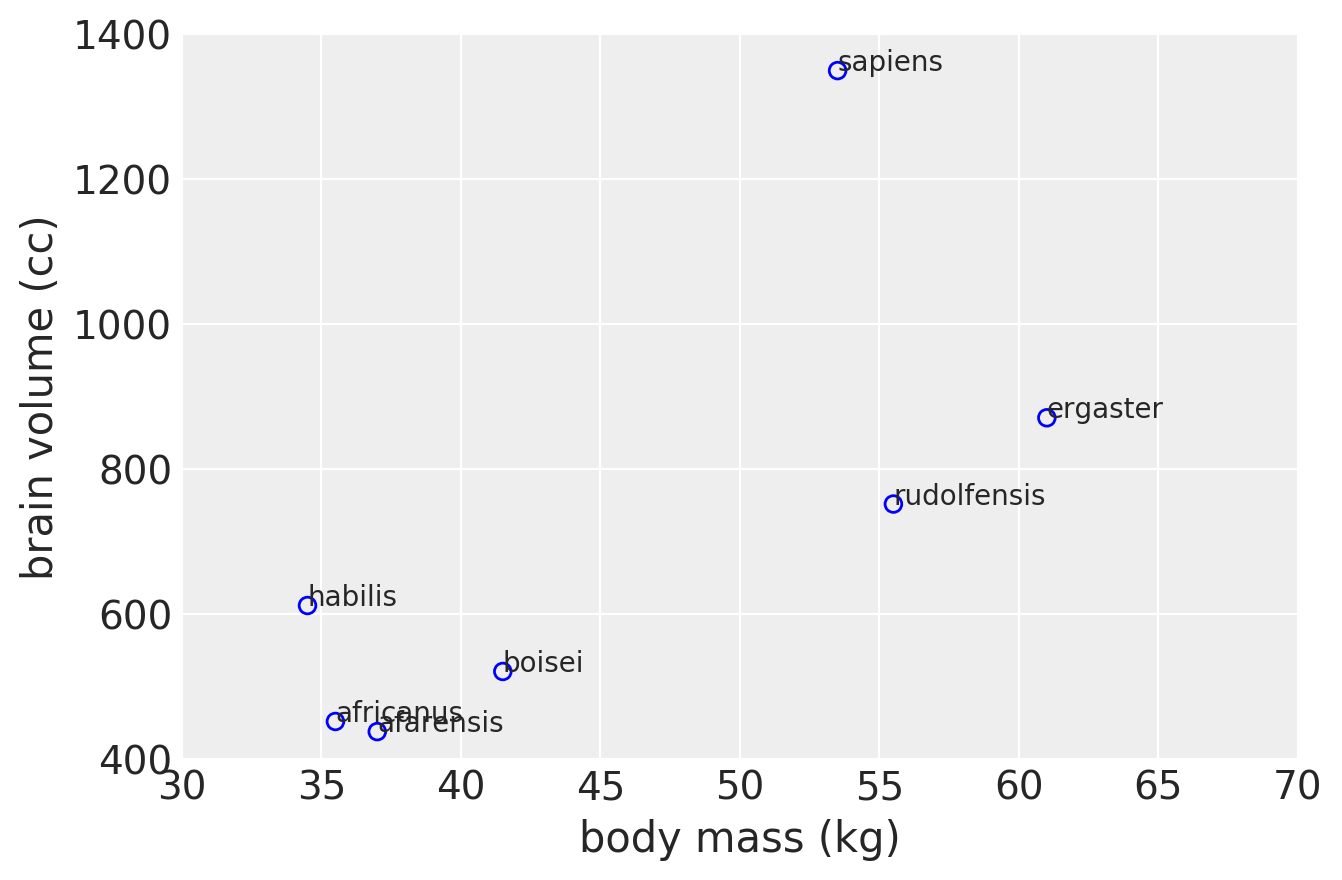

In [12]:
# Reproducing the figure in the book (there is no code fragment for this in R in the book)
plt.scatter(d.mass, d.brain, facecolors="none", edgecolors="b")
plt.gca().set(xlim=(30, 70), xlabel="body mass (kg)",
              ylim=(400,1400),
              ylabel="brain volume (cc)")

for i in range(d.shape[0]):
    plt.annotate(d.species[i], (d.mass[i], d.brain[i]))

## Code 7.2


Author talks about linear vs polynomial regression. He is of the opinion that most of the time polynomial regression is not a good idea (at least when used blindly). But why ?

In [13]:
d["mass_std"] = (d.mass - d.mass.mean()) / d.mass.std()
d["brain_std"] = d.brain / d.brain.max()

Note - brain is not standardized as such because you can not have -ive brain

## Code 7.3

Simplest model is the linear one and this is what we will start with

In [14]:
def model_7_1(mass_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.5, scale=1.0, name="alpha") , sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=10.0, name="beta") , sample_shape=1))
        sigma = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="sigma") , sample_shape=1))
        
        mu = alpha[...,tf.newaxis] + beta[...,tf.newaxis] * mass_std
        scale = sigma[...,tf.newaxis]        
        
        brain_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=tf.exp(scale)), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)  

In [15]:
jdc_7_1 = model_7_1(d["mass_std"].values)

In [16]:
init_state = [
    0.5 * tf.ones([NUMBER_OF_CHAINS]),
    tf.zeros([NUMBER_OF_CHAINS]),
    tf.zeros([NUMBER_OF_CHAINS]),
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
]

jdc = jdc_7_1
observed_data = (tf.cast(d["brain_std"].values, dtype=tf.float32),)

trace_7_1 = sample_from_posterior(
                    jdc, 
                    observed_data=observed_data,
                    params=['alpha', 'beta', 'sigma'],
                    num_samples=1000,
                    init_state=init_state,
                    bijectors=bijectors
                    )

## Code 7.4 [TODO !]

Use OLS for the above model

## Code 7.5


Variance explained or $R^2$ is defined as:

$R^2$ = 1 - $\frac{var(residuals)}{var(outcome)}$

In [17]:
posterior = trace_7_1.posterior

# We will have to simulate (compute) our posterior brain_std from the samples
sample_alpha = posterior["alpha"].values[0]
sample_beta = posterior["beta"].values[0]
sample_sigma = posterior["sigma"].values[0]

def compute_mu(m):
    mu = sample_alpha + sample_beta * m
    return mu

mu = np.array(list(map(compute_mu, d.mass_std.values))).T
scale = sample_sigma[...,np.newaxis]

sample_brain_std = tfd.Normal(loc=mu, scale=tf.exp(scale)).sample()

# get the mean
brain_std_mean = np.mean(sample_brain_std, 0)

r = brain_std_mean - d.brain_std.values

# compute the variance expained (R square)
resid_var = np.var(r, ddof=1)
outcome_var = np.var(d.brain_std.values, ddof=1)
1 - resid_var / outcome_var

0.4840983671088417

## Code 7.6

$R^2$ is bad, the author says ! ... here is  resuable function that will used multiple times later

In [49]:
def RX_is_bad(mu_fn, scale):     
    # note - here we compute for the dataset and not the sequence
    mu = np.array(list(map(mu_fn, d.mass_std.values))).T    
    
    sample_brain_std = tfd.Normal(loc=mu, scale=scale).sample()
    
    # get the mean
    brain_std_mean = np.mean(sample_brain_std, 0)        
    r = brain_std_mean - d.brain_std.values
    # compute the variance expained (R square)
    resid_var = np.var(r, ddof=1)
    outcome_var = np.var(d.brain_std.values, ddof=1)
    return 1 - resid_var / outcome_var

## Code 7.7

Building some more models to compare to m7.1

This one is a poymomial of second degree

In [40]:
def model_7_2(mass_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.5, scale=1.0, name="alpha") , sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=10.0, name="beta") , sample_shape=2))
        sigma = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="sigma") , sample_shape=1))
        
        beta1 = tf.squeeze(tf.gather(beta, [0], axis=-1))
        beta2 = tf.squeeze(tf.gather(beta, [1], axis=-1))
        
        mu = alpha[...,tf.newaxis] + beta1[...,tf.newaxis] * mass_std + \
                                     beta2[...,tf.newaxis] * mass_std ** 2
        
        scale = sigma[...,tf.newaxis]        
        
        brain_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=tf.exp(scale)), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)  

In [41]:
# will use this method for various models
def compute_brain_body_posterior_for_simulation(beta_degree, jdc):

    if beta_degree == 1:        
        init_state = [
            0.5 * tf.ones([NUMBER_OF_CHAINS]),
            tf.zeros([NUMBER_OF_CHAINS]),
            tf.zeros([NUMBER_OF_CHAINS]),
        ]
    else:    
        init_state = [
            0.5 * tf.ones([NUMBER_OF_CHAINS]),
            tf.zeros([NUMBER_OF_CHAINS, beta_degree]),
            tf.zeros([NUMBER_OF_CHAINS]),
        ]

    bijectors = [
        tfb.Identity(),
        tfb.Identity(),
        tfb.Identity(),
    ]
    
    observed_data = (tf.cast(d["brain_std"].values, dtype=tf.float32),)

    trace= sample_from_posterior(
                        jdc, 
                        observed_data=observed_data,
                        params=['alpha', 'beta', 'sigma'],
                        num_samples=1000,
                        init_state=init_state,
                        bijectors=bijectors
                        )
    
    return trace

## Code 7.8

Models of 3rd, 4th and 5th degrees

In [42]:
def model_7_3(mass_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.5, scale=1.0, name="alpha") , sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=10.0, name="beta") , sample_shape=3))
        sigma = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="sigma") , sample_shape=1))
        
        beta1 = tf.squeeze(tf.gather(beta, [0], axis=-1))
        beta2 = tf.squeeze(tf.gather(beta, [1], axis=-1))
        beta3 = tf.squeeze(tf.gather(beta, [2], axis=-1))
        
        mu = alpha[...,tf.newaxis] + beta1[...,tf.newaxis] * mass_std + \
                                     beta2[...,tf.newaxis] * mass_std ** 2 + \
                                     beta3[...,tf.newaxis] * mass_std ** 3
        
        scale = sigma[...,tf.newaxis]        
        
        brain_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=tf.exp(scale)), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)
                                          
                                          
def model_7_4(mass_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.5, scale=1.0, name="alpha") , sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=10.0, name="beta") , sample_shape=4))
        sigma = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="sigma") , sample_shape=1))
        
        beta1 = tf.squeeze(tf.gather(beta, [0], axis=-1))
        beta2 = tf.squeeze(tf.gather(beta, [1], axis=-1))
        beta3 = tf.squeeze(tf.gather(beta, [2], axis=-1))
        beta4 = tf.squeeze(tf.gather(beta, [3], axis=-1))                                          
        
        mu = alpha[...,tf.newaxis] + beta1[...,tf.newaxis] * mass_std + \
                                     beta2[...,tf.newaxis] * mass_std ** 2 + \
                                     beta3[...,tf.newaxis] * mass_std ** 3 + \
                                     beta4[...,tf.newaxis] * mass_std ** 4 
        
        scale = sigma[...,tf.newaxis]        
        
        brain_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=tf.exp(scale)), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)

def model_7_5(mass_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.5, scale=1.0, name="alpha") , sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=10.0, name="beta") , sample_shape=5))
        sigma = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="sigma") , sample_shape=1))
        
        beta1 = tf.squeeze(tf.gather(beta, [0], axis=-1))
        beta2 = tf.squeeze(tf.gather(beta, [1], axis=-1))
        beta3 = tf.squeeze(tf.gather(beta, [2], axis=-1))
        beta4 = tf.squeeze(tf.gather(beta, [3], axis=-1))                                        
        beta5 = tf.squeeze(tf.gather(beta, [4], axis=-1))                                        
        
        mu = alpha[...,tf.newaxis] + beta1[...,tf.newaxis] * mass_std + \
                                     beta2[...,tf.newaxis] * mass_std ** 2 + \
                                     beta3[...,tf.newaxis] * mass_std ** 3 + \
                                     beta4[...,tf.newaxis] * mass_std ** 4 + \
                                     beta5[...,tf.newaxis] * mass_std ** 5
        
        scale = sigma[...,tf.newaxis]        
        
        brain_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=tf.exp(scale)), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)

## Code 7.9

This one is of degree 6 but the standard deviation has been replaced with constant 0.001. The author mentions that otherwise it will not work and will be explained with the help of plot later

In [43]:
def model_7_6(mass_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.5, scale=1.0, name="alpha") , sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=10.0, name="beta") , sample_shape=6))        
        
        beta1 = tf.squeeze(tf.gather(beta, [0], axis=-1))
        beta2 = tf.squeeze(tf.gather(beta, [1], axis=-1))
        beta3 = tf.squeeze(tf.gather(beta, [2], axis=-1))
        beta4 = tf.squeeze(tf.gather(beta, [3], axis=-1))                                        
        beta5 = tf.squeeze(tf.gather(beta, [4], axis=-1))    
        beta6 = tf.squeeze(tf.gather(beta, [5], axis=-1))    
        
        mu = alpha[...,tf.newaxis] + beta1[...,tf.newaxis] * mass_std + \
                                     beta2[...,tf.newaxis] * mass_std ** 2 + \
                                     beta3[...,tf.newaxis] * mass_std ** 3 + \
                                     beta4[...,tf.newaxis] * mass_std ** 4 + \
                                     beta5[...,tf.newaxis] * mass_std ** 5 + \
                                     beta6[...,tf.newaxis] * mass_std ** 6        
        
        
        brain_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=0.001), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)

In [44]:
# for this method we need to compute the posterior differently as the model is different in terms of params
def compute_posterior_for_76_simulation(jdc_7_6):    

    init_state = [
        0.5 * tf.ones([NUMBER_OF_CHAINS]),
        tf.zeros([NUMBER_OF_CHAINS, 6])
    ]

    bijectors = [
        tfb.Identity(),
        tfb.Identity()
    ]
    
    observed_data = (tf.cast(d["brain_std"].values, dtype=tf.float32),)

    trace_7_6 = sample_from_posterior(
                        jdc_7_6, 
                        observed_data=observed_data,
                        params=['alpha', 'beta'],
                        num_samples=1000,
                        init_state=init_state,
                        bijectors=bijectors
                        )
    
    return trace_7_6

## Code 7.10

In [45]:
jdc_7_1 = model_7_1(d["mass_std"].values)
jdc_7_2 = model_7_2(d["mass_std"].values)
jdc_7_3 = model_7_3(d["mass_std"].values)
jdc_7_4 = model_7_4(d["mass_std"].values)
jdc_7_5 = model_7_5(d["mass_std"].values)    
jdc_7_6 = model_7_6(d["mass_std"].values)    

trace_7_1 = compute_brain_body_posterior_for_simulation(1, jdc_7_1)
trace_7_2 = compute_brain_body_posterior_for_simulation(2, jdc_7_2)
trace_7_3 = compute_brain_body_posterior_for_simulation(3, jdc_7_3)
trace_7_4 = compute_brain_body_posterior_for_simulation(4, jdc_7_4)
trace_7_5 = compute_brain_body_posterior_for_simulation(5, jdc_7_5)

trace_7_6 = compute_posterior_for_76_simulation(jdc_7_6)

In [25]:
mass_seq = np.linspace(d.mass_std.min(), d.mass_std.max(), num=100)

In [50]:
def plot_model_mean(model_name, trace, predictor_fn):    
    mu_fn = predictor_fn()    
    mu = np.array(list(map(mu_fn, mass_seq))).T
    
    mu_mean = np.mean(mu, 0)
    mu_ci = np.percentile(mu, (4.5, 95.5), 0)
    
    plt.scatter(d.mass_std, d.brain_std, facecolors="b", edgecolors="b")
    plt.plot(mass_seq, mu_mean, "k")
    
    plt.fill_between(mass_seq, mu_ci[0], mu_ci[1], color="k", alpha=0.2)
    
    if "sigma" in trace.posterior:    
        sigma = trace.posterior["sigma"].values[0]
        scale = tf.exp(sigma[...,np.newaxis])
    else:
        scale = 0.001  # model number 6
    
    plt.title("{}: R^2 = {:0.2f}".format(model_name, RX_is_bad(mu_fn, scale).item()));    

(1000, 7)
(1000, 1)


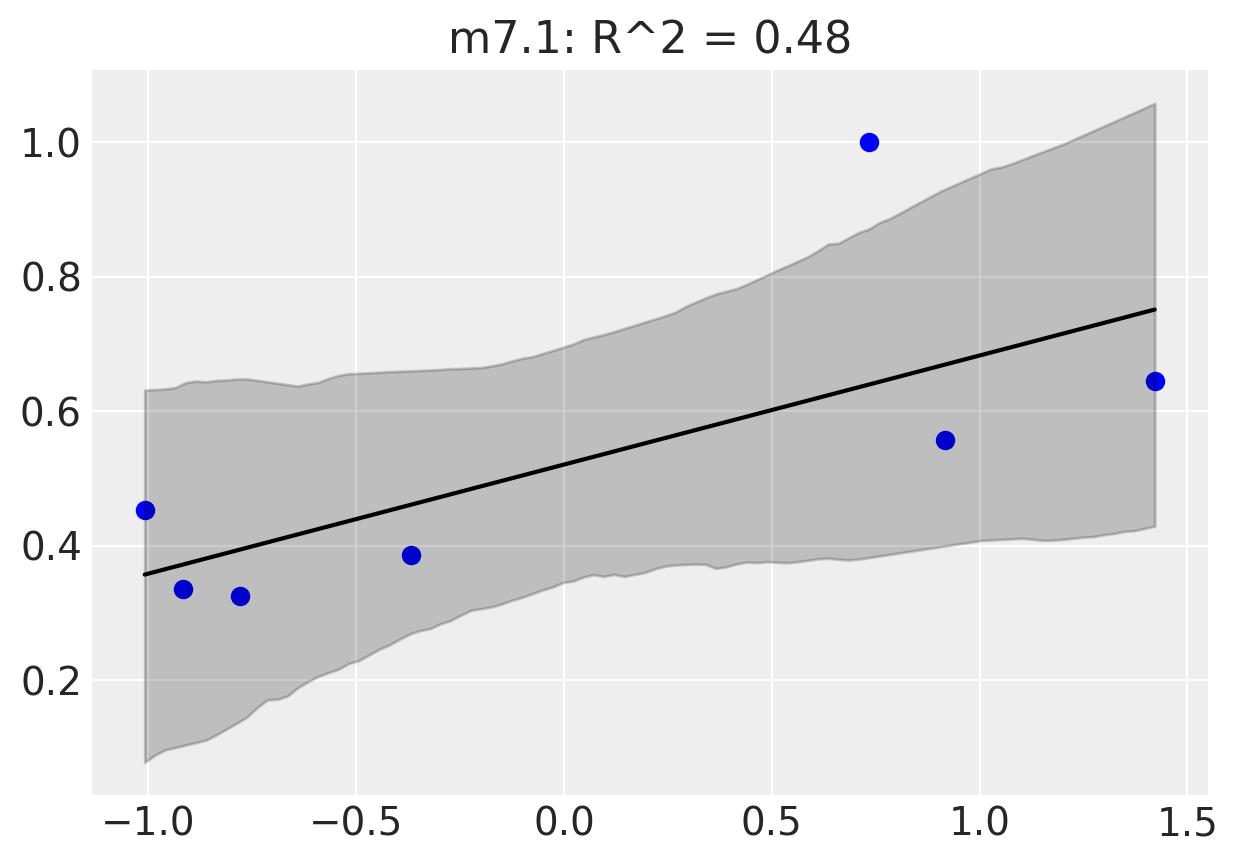

In [51]:
def predictor_m7_1():
    # We will have to simulate (compute) our posterior brain_std from the samples
    sample_alpha = trace_7_1.posterior["alpha"].values[0]
    sample_beta = trace_7_1.posterior["beta"].values[0]    
    
    def compute_mu71(m):
        mu = sample_alpha + sample_beta * m        
        return mu    

    return compute_mu71
    
    
plot_model_mean("m7.1", trace_7_1, predictor_m7_1)

(1000, 7)


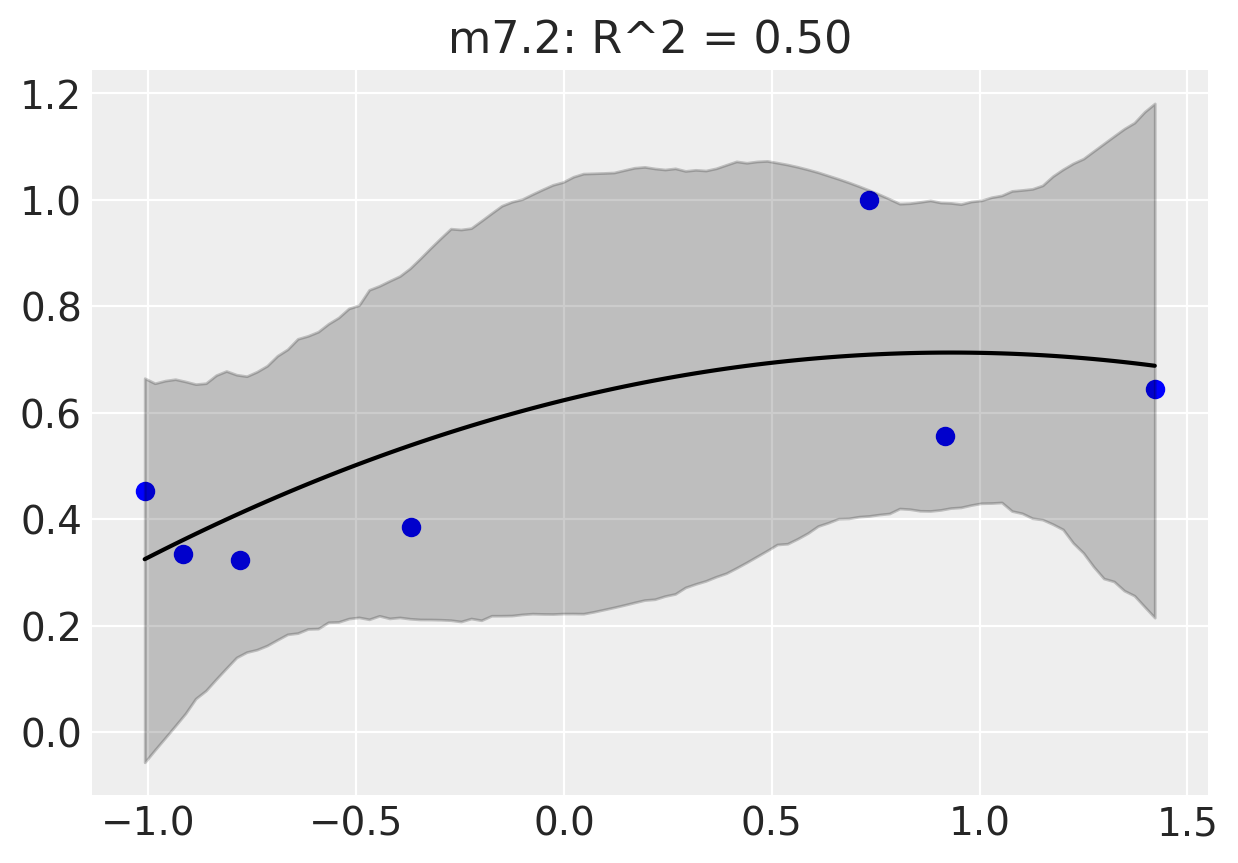

In [48]:
# Book does not provide the code snippet for other models but has corresponding figures so I am 
# doing that as well

def predictor_m7_2():
    # We will have to simulate (compute) our posterior brain_std from the samples
    sample_alpha = trace_7_2.posterior["alpha"].values[0]
    sample_beta = trace_7_2.posterior["beta"].values[0]        
    
    def compute_mu72(m):        
        mu = sample_alpha + sample_beta[:,0] * m +\
                            sample_beta[:,1] * m ** 2
        return mu
    
    return compute_mu72
    
    
plot_model_mean("m7.2", trace_7_2, predictor_m7_2)

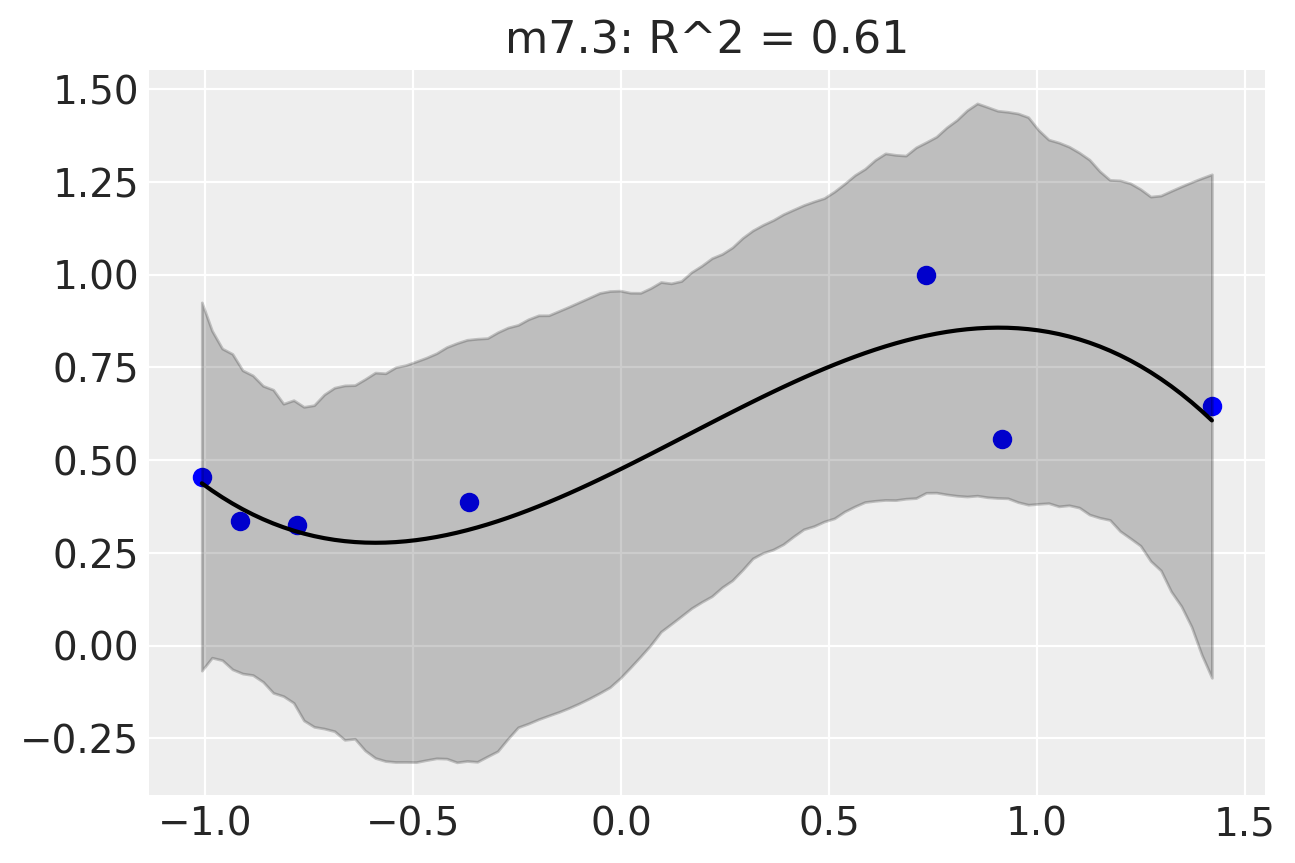

In [29]:
def predictor_m7_3():
    # We will have to simulate (compute) our posterior brain_std from the samples
    sample_alpha = trace_7_3.posterior["alpha"].values[0]
    sample_beta = trace_7_3.posterior["beta"].values[0]        
    
    def compute_mu(m):
        mu = sample_alpha + sample_beta[:,0] * m + \
                            sample_beta[:,1] * m **2 +\
                            sample_beta[:,2] * m **3
        return mu   
    
    return compute_mu
    
    
plot_model_mean("m7.3", trace_7_3, predictor_m7_3)

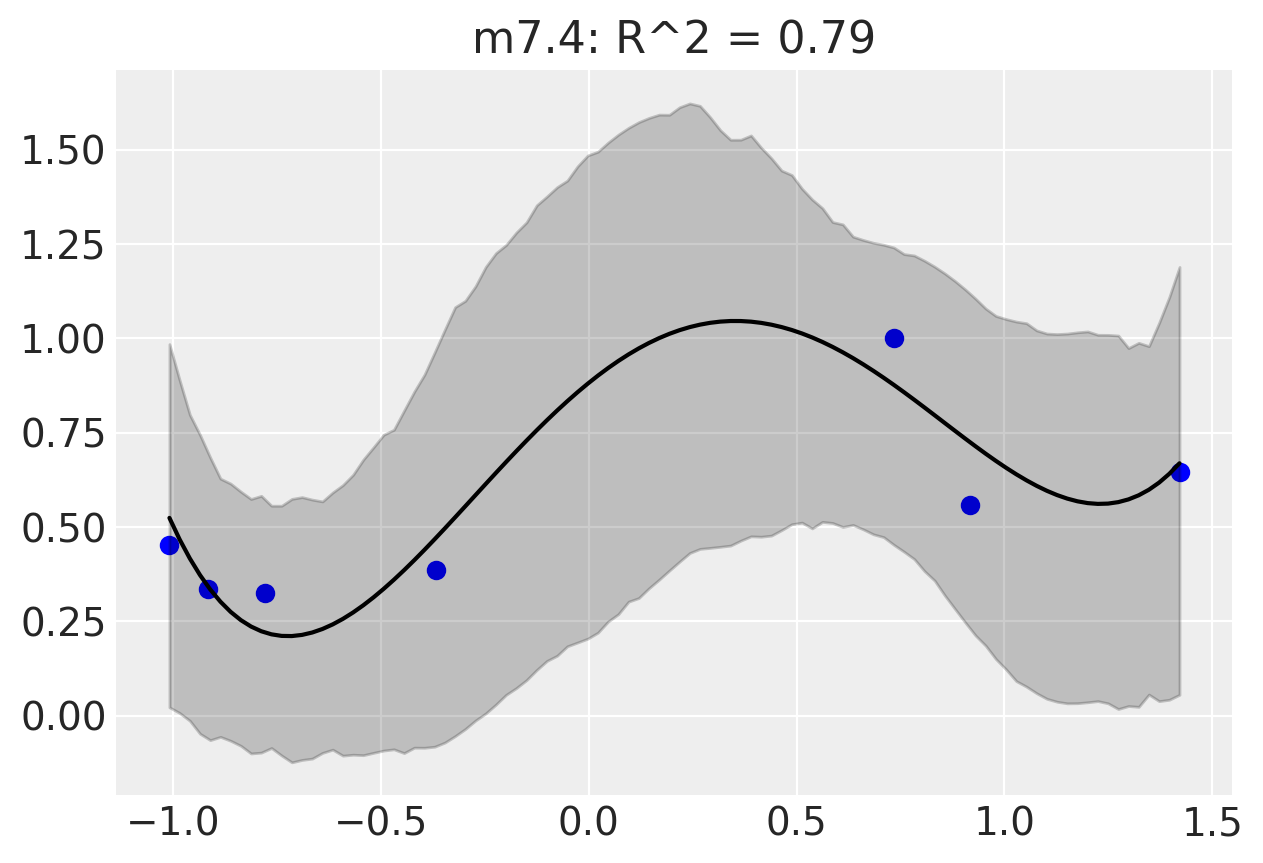

In [30]:
def predictor_m7_4():
    # We will have to simulate (compute) our posterior brain_std from the samples
    sample_alpha = trace_7_4.posterior["alpha"].values[0]
    sample_beta = trace_7_4.posterior["beta"].values[0]    
    
    def compute_mu(m):
        mu = sample_alpha + sample_beta[:,0] * m + \
                            sample_beta[:,1] * m ** 2 + \
                            sample_beta[:,2] * m ** 3 + \
                            sample_beta[:,3] * m ** 4
        return mu
    
    return compute_mu
    
    
plot_model_mean("m7.4", trace_7_4, predictor_m7_4)

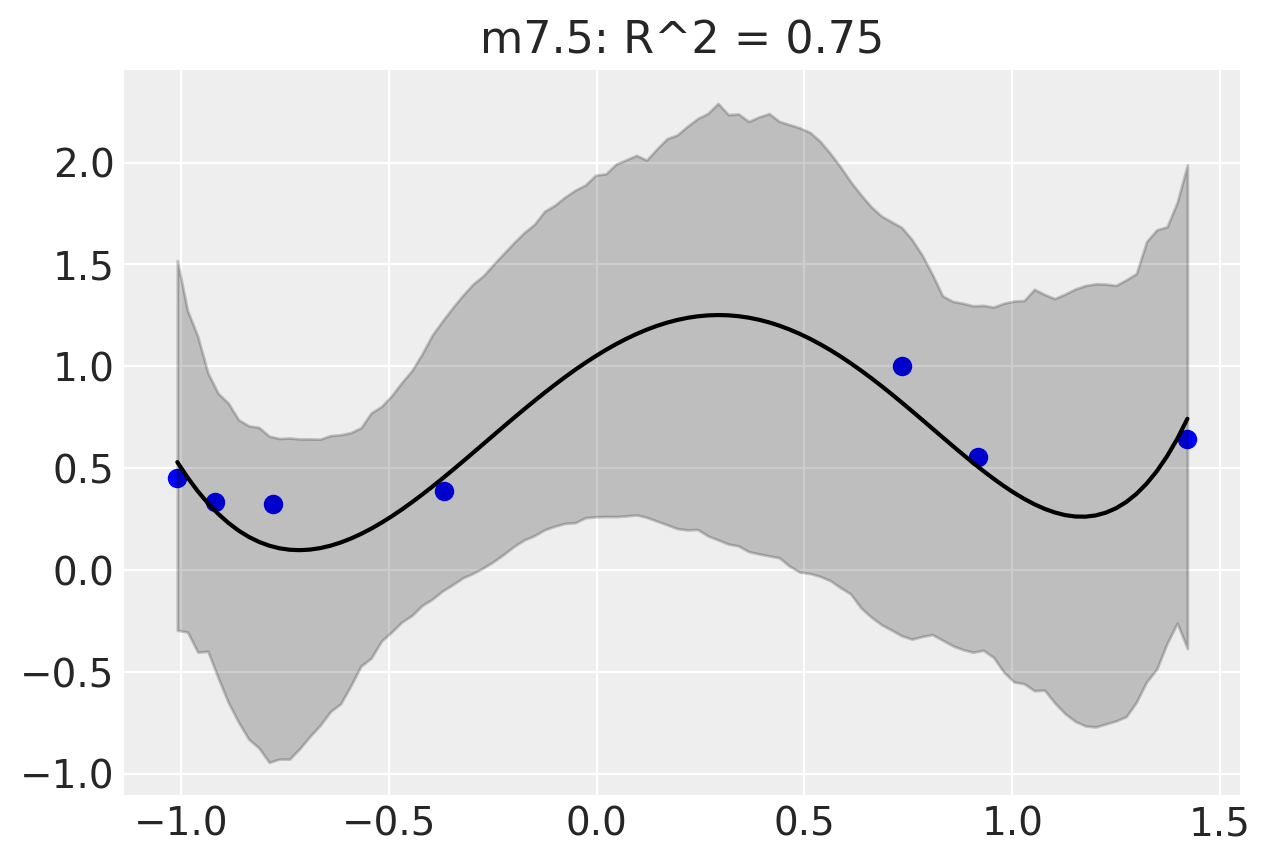

In [31]:
def predictor_m7_5():
    # We will have to simulate (compute) our posterior brain_std from the samples
    sample_alpha = trace_7_5.posterior["alpha"].values[0]
    sample_beta = trace_7_5.posterior["beta"].values[0]        
    
    def compute_mu(m):
        mu = sample_alpha + sample_beta[:,0] * m + \
                            sample_beta[:,1] * m ** 2 + \
                            sample_beta[:,2] * m ** 3 + \
                            sample_beta[:,3] * m ** 4 + \
                            sample_beta[:,4] * m ** 5 
        return mu    
    
    return compute_mu
    
    
plot_model_mean("m7.5", trace_7_5, predictor_m7_5)

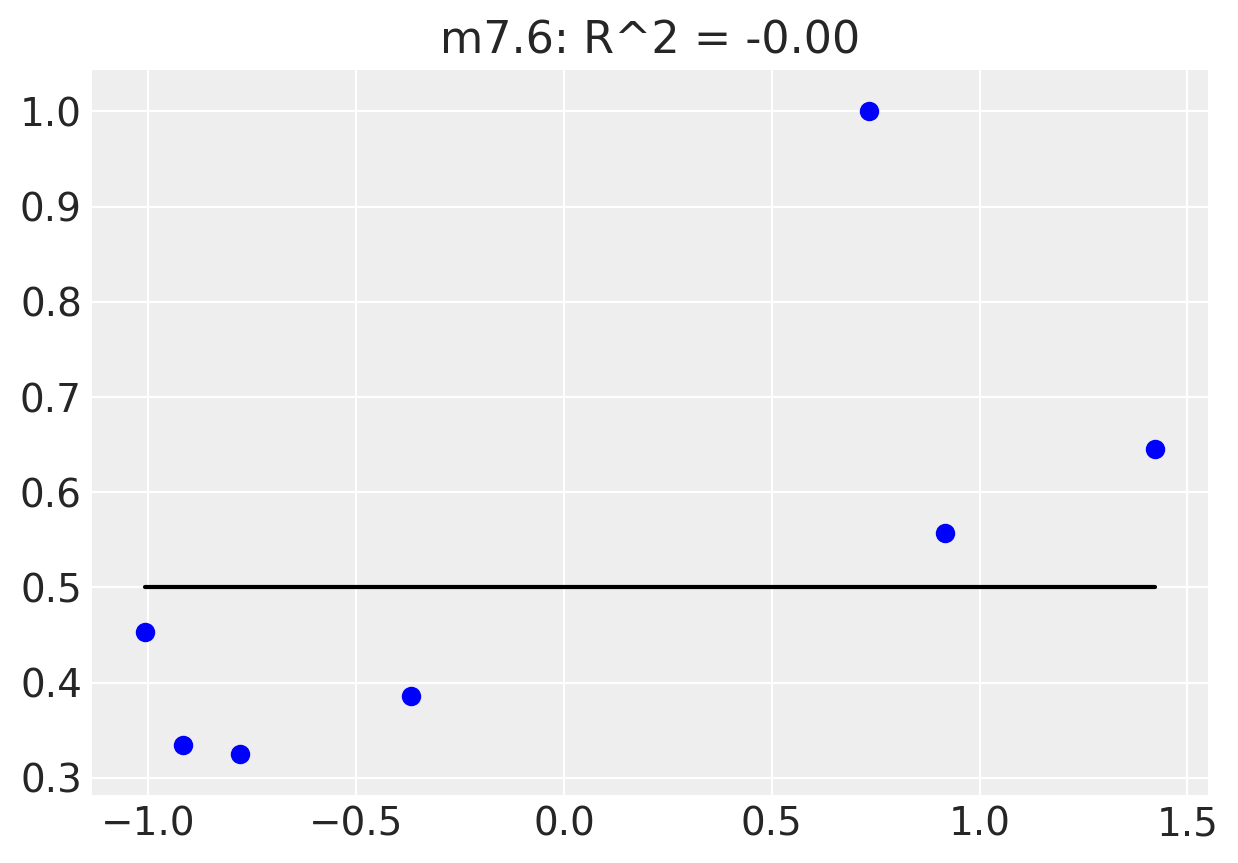

In [32]:
def predictor_m7_6():
    # We will have to simulate (compute) our posterior brain_std from the samples
    sample_alpha = trace_7_6.posterior["alpha"].values[0]
    sample_beta = trace_7_6.posterior["beta"].values[0]        
    
    def compute_mu(m):
        mu = sample_alpha + sample_beta[:,0] * m + \
                            sample_beta[:,1] * m ** 2 + \
                            sample_beta[:,2] * m ** 3 + \
                            sample_beta[:,3] * m ** 4 + \
                            sample_beta[:,4] * m ** 5 + \
                            sample_beta[:,5] * m ** 6
        return mu   
    
    return compute_mu
    
    
plot_model_mean("m7.6", trace_7_6, predictor_m7_6)

## Code 7.11

In [52]:
i = 1
d_minus_i = d.drop(i)

## Code 7.12

In [53]:
p = np.array([0.3, 0.7])
-np.sum(p * np.log(p))

0.6108643020548935